#Cleaning Data
## Por: José Guarnizo


Nombre de la variable	Descripción
* Item_Identifier	Número de identificación único del producto
* Item_Weight	Peso del producto
* Item_Fat_Content	Si el producto es bajo en grasas o regular
* Item_Visibility	El porcentaje de área total de visualización de todos los productos en la tienda asignados a este producto particular
* Item_Type	La categoría a la que pertenece el producto
* Item_MRP	Precio Máximo Minorista (precio de lista) del producto
* Outlet_Identifier	Número de identificación único de la tienda
* Outlet_Establishment_Year	El año en el que se estableció la tienda
* Outlet_Size	El tamaño de la tienda en cuanto a la superficie total que cubre
* Outlet_Location_Type	El tipo de área donde se ubica la tienda
* Outlet_Type	Si la tienda es un almacén o algún tipo de supermercado
* Item_Outlet_Sales	Las ventas del producto en la tienda particular. Esta es la * variable objetivo que se debe predecir.

#Librerías y lectura de archivo

##Importación de Librerías

In [1]:
pip install category_encoders

     |████████████████████████████████| 82 kB 385 kB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import category_encoders as ce

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##Lectura de archivo sales_predictions.csv desde repositorio Github
* Se guarda archivo en variable df

In [3]:
filename='https://raw.githubusercontent.com/JGuarnizo/Sales-Predictions/51d233017c983387a05c8d0f96e793e1913002f6/sales_predictions.csv'


In [4]:
df=pd.read_csv(filename)

# Data Cleaning (Parte 2)

## Inspección del data frame
* Existen 8523 observaciones. 
* Hay 5 variables númericas y 6 categoricas
* Se encuentran 2 variables númericas con datos faltantes. 
** Se obtiene porcentaje de datos faltantes
** 1. Item_Weight (Float) 17.2%
** 2. Outlet_Size (Object) 28.2%
* La variable categórica 'Item_Fat_Content' tiene datos duplicados
** Low Fat = LF, low fat
** Regular = reg


In [5]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [6]:
#Información del data frame
#Existen 2 columnas con datos faltantes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [7]:
#Se obtiene un porcentaje de datos faltantes
round((df.isna().sum()/len(df))*100,1)

Item_Identifier               0.0
Item_Weight                  17.2
Item_Fat_Content              0.0
Item_Visibility               0.0
Item_Type                     0.0
Item_MRP                      0.0
Outlet_Identifier             0.0
Outlet_Establishment_Year     0.0
Outlet_Size                  28.3
Outlet_Location_Type          0.0
Outlet_Type                   0.0
Item_Outlet_Sales             0.0
dtype: float64

In [8]:
#Se explora variable categórica 'Item_Fat_Content' en busca de valores únicos. 
#Se encuentra valores mal declarados repetidos Low Fat = LF lowfat & Regular=reg. 
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [9]:
#Se explora variable categórica 'Item_Type'.
#Todos los valores únicos se encuentran bien declarados
df['Item_Type'].value_counts()

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

In [10]:
#Se explora variable categórica 'Outlet_Location_Type'.
#Todos los valores únicos se encuentran bien declarados
df['Outlet_Location_Type'].value_counts()


Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

## Rellenar valores Outlet_Size
* La variable Outlet_Size esta ligada a la variable Outlet_Identifier. Por o tanto, se agrupa por Outlet_Identifier y se observa que 3 tiendas no tienen definido su Outlet_Size. La tiendas son: OUT010, OUT017 Y LA OUT045
* Se intenta encontrar alguna relación entre Outlet_Size y Outlet_type para rellenar valores faltantes, pero no hay ninguna relación.
* Si se borran todas las obsrvaciones donde Outlet_Size==NaN entonces se borraría la información de 3 tiendas, por lo tanto no aplica.
* CONCLUSIÓN: Outlet_Size es una variable categórica que no aporta mayor información. Como no se tiene parámetros de como fue creada, se desconoce a que tamaño se refiere Small, Medium o High. Se puede eliminar pero en este caso la ignoraremos en nuestro data frame. Como los algoritmos requieren datos no nulos, se reemplazará los datos NaN como Unknown

In [11]:
#Outlet_Size es el tamaño de cada tienda. Existe un número limitado de tiendas y cada tienda debe tener un tamaño fijo. 
df.groupby(['Outlet_Identifier'])['Outlet_Size'].max()

Outlet_Identifier
OUT010       NaN
OUT013      High
OUT017       NaN
OUT018    Medium
OUT019     Small
OUT027    Medium
OUT035     Small
OUT045       NaN
OUT046     Small
OUT049    Medium
Name: Outlet_Size, dtype: object

In [12]:
df.groupby(['Outlet_Identifier'])['Outlet_Size','Outlet_Type'].min()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,Outlet_Size,Outlet_Type
Outlet_Identifier,,
OUT010,NaN,Grocery Store
OUT013,High,Supermarket Type1
OUT017,NaN,Supermarket Type1
OUT018,Medium,Supermarket Type2
OUT019,Small,Grocery Store
OUT027,Medium,Supermarket Type3
OUT035,Small,Supermarket Type1
OUT045,NaN,Supermarket Type1
OUT046,Small,Supermarket Type1


In [13]:
df.groupby(['Outlet_Identifier','Outlet_Size','Outlet_Type','Outlet_Location_Type'])['Item_Outlet_Sales'].sum().sort_values(ascending=False)

Outlet_Identifier  Outlet_Size  Outlet_Type        Outlet_Location_Type
OUT027             Medium       Supermarket Type3  Tier 3                  3.453926e+06
OUT035             Small        Supermarket Type1  Tier 2                  2.268123e+06
OUT049             Medium       Supermarket Type1  Tier 1                  2.183970e+06
OUT013             High         Supermarket Type1  Tier 3                  2.142664e+06
OUT046             Small        Supermarket Type1  Tier 1                  2.118395e+06
OUT018             Medium       Supermarket Type2  Tier 3                  1.851823e+06
OUT019             Small        Grocery Store      Tier 1                  1.796941e+05
Name: Item_Outlet_Sales, dtype: float64

In [14]:
df.groupby(['Outlet_Identifier'])['Item_Outlet_Sales'].sum().sort_values(ascending=False)

Outlet_Identifier
OUT027    3.453926e+06
OUT035    2.268123e+06
OUT049    2.183970e+06
OUT017    2.167465e+06
OUT013    2.142664e+06
OUT046    2.118395e+06
OUT045    2.036725e+06
OUT018    1.851823e+06
OUT010    1.883402e+05
OUT019    1.796941e+05
Name: Item_Outlet_Sales, dtype: float64

In [15]:
df['Outlet_Size']=df['Outlet_Size'].fillna('Unknown')

##Rellenar valores Item_Weight
* Enfoque 1:
Se obtiene la lista única de Tiendas en la base de datos (Outlet_Identifier). Después se realizará un filtro para eliminar todas las observaciones donde Item_Weight==NaN, y se revisará si la lista única de Tiendas permanece igual.
* Conclusión:
Si se eliminan todos los valores donde Item_Weight==NaN se elimina la información completa de 2 tiendas. Por lo tanto, este enfoque no se aplica
* Enfoque 2:
Se conoce que se tiene el 17% de datos perdidos en la columna Item_Weight, sin embargo, el Item_Weight esta asociado a un Item_Identifier, y estos (Item_Identifier) se repiten para 1 o más tiendas, es decir, se puede copiar la información faltante ordenando por Item_Identifier y copiar la información de un producto que se venda en otra tienda.
** Primero se agrupará por Item_Identifier y se analizará cuantos elementos no tienen Item_Weight en toda la base. Se analizará cuál es el impacto de venta en la Item_Outlet_Sales en cada tienda que se venda y si el porcentaje es despreciable menor a 0.5% se eliminarán dichas observaciones.
Luego, para todos los valores restantes se puede ordenar la base de datos por Item_Identifier y copiar los valores con el comando fillna(method='bfill').

* Conclusión:
Se eliminan 4 filas (observaciones) de la base de datos y el resto se rellena con el comando fillna(method='bfill') previamente ordenando la base de datos por Item_Identifier. 
* La nueva base de datos funcional queda como df_final

###Enfoque 1:

In [16]:
#Tiendas existentes en la base de datos
#Existen 10 tiendas en total
df['Outlet_Identifier'].value_counts()

OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64

In [17]:
#Si se decide eliminar todos las observaciones donde Item_Weight==NaN, entonces se eliminaría la información completa de 2 tiendas
#OUT027 & OUT019 ya no aparecen en la base filtrada.
#Por lo tanto, no se puede borrar todas las observaciones
filtro = df['Item_Weight'].isna() 
df.loc[~filtro,:]['Outlet_Identifier'].value_counts()

OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
Name: Outlet_Identifier, dtype: int64

###Enfoque 2:

In [18]:
#Se comprueba que existe un valor único de Item_Weight para cada Item_Identifier
df['Item_Identifier'].value_counts().count()

1559

In [19]:
#Existen 1559 Item_Identifier, sin embargo, sólo existe un valor único para 1555.
#Por lo tanto, existen 4 Item_Identifier que no tienen información de su Item_Weight
df.groupby(['Item_Identifier'])['Item_Weight'].value_counts()

Item_Identifier  Item_Weight
DRA12            11.600         6
DRA24            19.350         5
DRA59            8.270          6
DRB01            7.390          2
DRB13            6.115          5
                               ..
NCZ30            6.590          6
NCZ41            19.850         5
NCZ42            10.500         5
NCZ53            9.600          4
NCZ54            14.650         5
Name: Item_Weight, Length: 1555, dtype: int64

In [20]:
#Se determina cuáles Item_Identifier realmente no tienen Item_Weight
empty_arr=df.groupby(['Item_Identifier'])['Item_Weight'].mean().isna()
empty_weight_item=[]

for i in range(len(empty_arr)):
  if empty_arr[i]==True:
    empty_weight_item.append(empty_arr.index[i])

empty_weight_item

['FDE52', 'FDK57', 'FDN52', 'FDQ60']

In [21]:
#Se crea un filtro para saber cuántos registros con Item_Identifier son iguales a los valores de ['FDE52', 'FDK57', 'FDN52', 'FDQ60']
#Se observa que los 4 items sólo son vendidos en 2 tiendas en la OUT027 & OUT019
filtro=(df['Item_Identifier']==empty_weight_item[0]
        )|(df['Item_Identifier']==empty_weight_item[1]
        )|(df['Item_Identifier']==empty_weight_item[2]
        )|(df['Item_Identifier']==empty_weight_item[3])

df_empty_weight=df.loc[filtro,:]
df_empty_weight.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
927,FDN52,NaN,Regular,0.130933,Frozen Foods,86.9198,OUT027,1985,Medium,Tier 3,Supermarket Type3,1569.9564
1922,FDK57,NaN,Low Fat,0.079904,Snack Foods,120.0440,OUT027,1985,Medium,Tier 3,Supermarket Type3,4434.2280
4187,FDE52,NaN,Regular,0.029742,Dairy,88.9514,OUT027,1985,Medium,Tier 3,Supermarket Type3,3453.5046
5022,FDQ60,NaN,Regular,0.191501,Baking Goods,121.2098,OUT019,1985,Small,Tier 1,Grocery Store,120.5098


In [22]:
#Se evalúa cuál es el impacto de la venta de esos 4 items en sus repectivas tiendas

#Ventas totales por tienda
total_sales=df.groupby(['Outlet_Identifier'])['Item_Outlet_Sales'].sum()

#Porcentaje de ventas de los items de empty_weight_item en sus respectivas tiendas
for i in df_empty_weight.index:
  print('\nEl',df_empty_weight.loc[i,'Item_Identifier'],'en la tienda',df_empty_weight.loc[i,'Outlet_Identifier'])
  print((df_empty_weight.loc[i,'Item_Outlet_Sales']/total_sales[df_empty_weight.loc[i,'Outlet_Identifier']])*100,'% de las ventas totales')



El FDN52 en la tienda OUT027
0.04545425630533232 % de las ventas totales

El FDK57 en la tienda OUT027
0.12838225063338135 % de las ventas totales

El FDE52 en la tienda OUT027
0.09998779790320558 % de las ventas totales

El FDQ60 en la tienda OUT019
0.06706386258206987 % de las ventas totales


In [23]:
#Se elimina las 4 observaciones anteriores, debido a que no son relevantes.
#Se crea nuestro data frame final, con nombre df_final
df_final=df.loc[~filtro,:]
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8519 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8519 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8519 non-null   object 
 3   Item_Visibility            8519 non-null   float64
 4   Item_Type                  8519 non-null   object 
 5   Item_MRP                   8519 non-null   float64
 6   Outlet_Identifier          8519 non-null   object 
 7   Outlet_Establishment_Year  8519 non-null   int64  
 8   Outlet_Size                8519 non-null   object 
 9   Outlet_Location_Type       8519 non-null   object 
 10  Outlet_Type                8519 non-null   object 
 11  Item_Outlet_Sales          8519 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 865.2+ KB


In [24]:
#Se rellena valores Item_Weight faltantes

#Se ordena df_final por Item_Identifier
df_final=df_final.sort_values(by=['Item_Identifier'])

#Se completa los valores faltantes de Item_Weight.
#Se toma la información de otro producto vendido en otra tienda
df_final.loc[:,'Item_Weight']=df_final.loc[:,'Item_Weight'].fillna(method='bfill')

#Se vuelve a ordena df_final por índice
df_final=df_final.sort_index()
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8519 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8519 non-null   object 
 1   Item_Weight                8519 non-null   float64
 2   Item_Fat_Content           8519 non-null   object 
 3   Item_Visibility            8519 non-null   float64
 4   Item_Type                  8519 non-null   object 
 5   Item_MRP                   8519 non-null   float64
 6   Outlet_Identifier          8519 non-null   object 
 7   Outlet_Establishment_Year  8519 non-null   int64  
 8   Outlet_Size                8519 non-null   object 
 9   Outlet_Location_Type       8519 non-null   object 
 10  Outlet_Type                8519 non-null   object 
 11  Item_Outlet_Sales          8519 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 865.2+ KB


## Corrección de valores duplicados en la columna 'Item_Fat_Content'
* Se corrige valores duplicados en la columna 'Item_Fat_Content'
Se tiene 5 valores únicos ['Low Fat', 'Regular', 'low fat', 'LF', 'reg'] pero sólo deberían haber 2 ['Low Fat', 'Regular']

In [25]:
#Se tiene 5 valores únicos ['Low Fat', 'Regular', 'low fat', 'LF', 'reg'] pero sólo deberían haber 2
#['Low Fat', 'Regular']
df_final['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [26]:
#Se corrige problema reemplazando valores repetidos
df_final['Item_Fat_Content'] = np.where(df_final['Item_Fat_Content']=='low fat', 'Low Fat', df_final['Item_Fat_Content'])
df_final['Item_Fat_Content'] = np.where(df_final['Item_Fat_Content']=='LF', 'Low Fat', df_final['Item_Fat_Content'])
df_final['Item_Fat_Content'] = np.where(df_final['Item_Fat_Content']=='reg', 'Regular', df_final['Item_Fat_Content'])
df_final['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular'], dtype=object)

## Análisis de datos
* Variables númericas: 'Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales'
* Lista de tipos de elementos que se venden en las distintas tiendas
* Lista ordenada de mayor a menor de las tiendas que más venden
* Lista ordenada de mayor a menor de los tipos de productos que más se venden.

In [27]:
# Valores mínimos, máximos, desviación estándar de variables numéricas
df_final.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8519.000000,8519.000000,8519.000000,8519.000000,8519.000000
mean,12.878478,0.066112,141.010019,1997.837892,2181.188779
std,4.653350,0.051586,62.283594,8.369105,1706.511093
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.780000,0.026983,93.844900,1987.000000,834.247400
50%,12.650000,0.053925,143.047000,1999.000000,1794.331000
75%,16.850000,0.094558,185.676600,2004.000000,3100.630600
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


* La variable Outlet_Establishment_Year, es el año de apertura de la tienda y no nos aporta mayor información para las ventas.
* La variable Item_Outlet_Sales tiene valores bastante dispersos, pero, es debido a la diferencia de los productos que se vende.


In [28]:
#Obtenemos lista de tipos de elementos que se venden en las distintas tiendas
df['Item_Type'].value_counts()

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

In [29]:
#Lista ordenada de mayor a menor de las tiendas que más venden
df.groupby(['Outlet_Identifier'])[['Item_Outlet_Sales']].sum().sort_values(by='Item_Outlet_Sales', ascending=False)

,Item_Outlet_Sales
Outlet_Identifier,
OUT027,3.453926e+06
OUT035,2.268123e+06
OUT049,2.183970e+06
OUT017,2.167465e+06
OUT013,2.142664e+06
OUT046,2.118395e+06
OUT045,2.036725e+06
OUT018,1.851823e+06
OUT010,1.883402e+05


In [30]:
#Lista ordenada de mayor a menor de los tipos de productos que más se venden.
df.groupby(['Item_Type'])[['Item_Outlet_Sales']].sum().sort_values(by='Item_Outlet_Sales', ascending=False)

,Item_Outlet_Sales
Item_Type,
Fruits and Vegetables,2.820060e+06
Snack Foods,2.732786e+06
Household,2.055494e+06
Frozen Foods,1.825735e+06
Dairy,1.522594e+06
Canned,1.444151e+06
Baking Goods,1.265525e+06
Health and Hygiene,1.045200e+06
Meat,9.175656e+05


In [31]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8519 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8519 non-null   object 
 1   Item_Weight                8519 non-null   float64
 2   Item_Fat_Content           8519 non-null   object 
 3   Item_Visibility            8519 non-null   float64
 4   Item_Type                  8519 non-null   object 
 5   Item_MRP                   8519 non-null   float64
 6   Outlet_Identifier          8519 non-null   object 
 7   Outlet_Establishment_Year  8519 non-null   int64  
 8   Outlet_Size                8519 non-null   object 
 9   Outlet_Location_Type       8519 non-null   object 
 10  Outlet_Type                8519 non-null   object 
 11  Item_Outlet_Sales          8519 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 865.2+ KB


# Data Visualization (Parte 3)

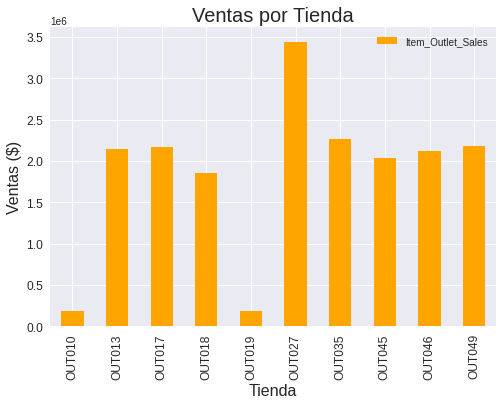

In [32]:
#Ventas por tienda
plt.style.use('seaborn')
sales_outlet=df_final.groupby(['Outlet_Identifier'])[['Item_Outlet_Sales']].sum()
sales_outlet.plot.bar(color='orange');
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Tienda', fontsize=16)
plt.ylabel('Ventas ($)', fontsize=16)
plt.title('Ventas por Tienda', fontsize=20);

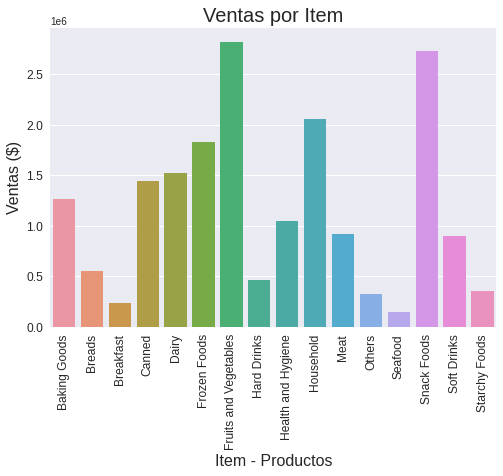

In [33]:
#Ventas por categoría
sales_item=df_final.groupby(['Item_Type'])[['Item_Outlet_Sales']].sum()
sns.barplot(x=sales_item.index, y=sales_item.values.ravel())
plt.xticks(fontsize = 12, rotation=90)
plt.yticks(fontsize = 12)
plt.xlabel('Item - Productos', fontsize=16)
plt.ylabel('Ventas ($)', fontsize=16)
plt.title('Ventas por Item', fontsize=20);

#Histogramas y Diagramas de Caja (Parte 4)

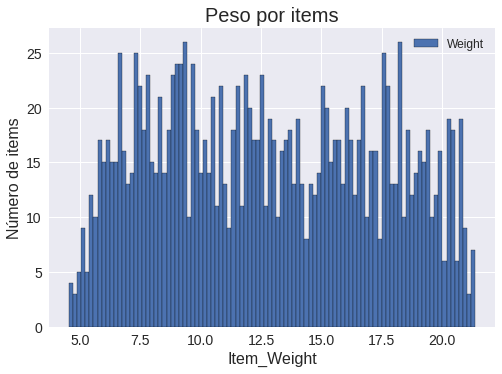

In [312]:
#Histograma que muestra la distribución por peso de todos los items.
item_weight=df_final.groupby(['Item_Identifier'])['Item_Weight'].mean()
item_weight.hist(bins=100, edgecolor='black',label = 'Weight')
plt.legend(loc='upper right', fontsize=12)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Item_Weight', fontsize=16)
plt.ylabel('Número de items', fontsize=16)
plt.title('Peso por items', fontsize=20);

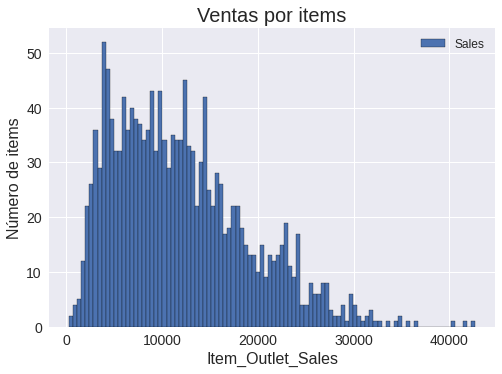

In [314]:
#Histograma que muestra la distribución por peso de todos los items.
item_sales=df_final.groupby(['Item_Identifier'])['Item_Outlet_Sales'].sum()
item_sales.hist(bins=100, edgecolor='black',label = 'Sales')
plt.legend(loc='upper right', fontsize=12)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Item_Outlet_Sales', fontsize=16)
plt.ylabel('Número de items', fontsize=16)
plt.title('Ventas por items', fontsize=20);

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


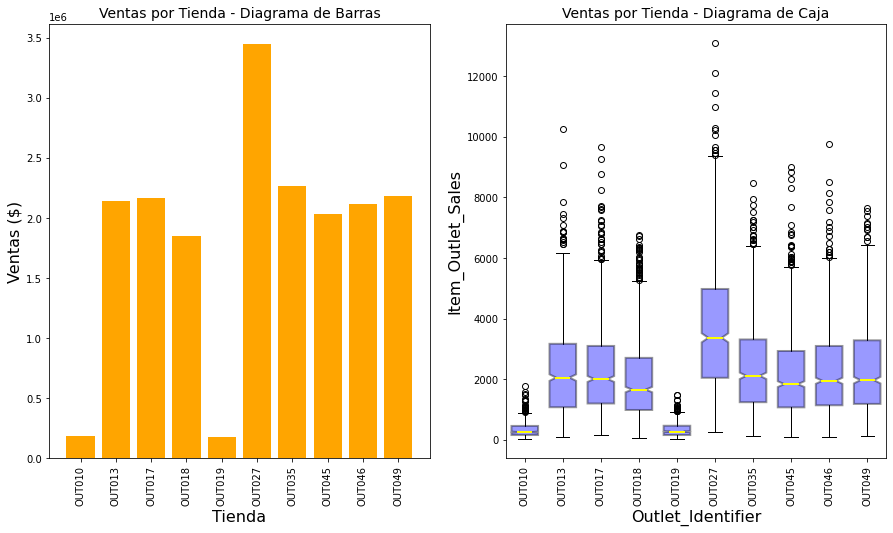

In [126]:
#Diagrama de caja
#Muestra la distribución de todas las ventas que tiene cada tienda.
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15,8));

sales_outlet=df_final.groupby(['Outlet_Identifier'])[['Item_Outlet_Sales']].sum()
axes[0].bar(sales_outlet.index,sales_outlet.values.ravel(),color='orange')
axes[0].tick_params(axis='x', labelrotation=90)
axes[0].set_xlabel('Tienda', fontsize=16)
axes[0].set_ylabel('Ventas ($)', fontsize=16)
axes[0].set_title('Ventas por Tienda - Diagrama de Barras', fontsize=14);


axes[1].boxplot([df_final.loc[df_final.Outlet_Identifier=='OUT010','Item_Outlet_Sales']
              ,df_final.loc[df_final.Outlet_Identifier=='OUT013','Item_Outlet_Sales']
              ,df_final.loc[df_final.Outlet_Identifier=='OUT017','Item_Outlet_Sales']
              ,df_final.loc[df_final.Outlet_Identifier=='OUT018','Item_Outlet_Sales']
              ,df_final.loc[df_final.Outlet_Identifier=='OUT019','Item_Outlet_Sales']
              ,df_final.loc[df_final.Outlet_Identifier=='OUT027','Item_Outlet_Sales']
              ,df_final.loc[df_final.Outlet_Identifier=='OUT035','Item_Outlet_Sales']
              ,df_final.loc[df_final.Outlet_Identifier=='OUT045','Item_Outlet_Sales']
              ,df_final.loc[df_final.Outlet_Identifier=='OUT046','Item_Outlet_Sales']
              ,df_final.loc[df_final.Outlet_Identifier=='OUT049','Item_Outlet_Sales']
              ],
           labels=sales_outlet.index,             
           notch = True,
           widths = .7,
           patch_artist=True,
           medianprops = dict(linestyle='-', linewidth=2, color='Yellow'),
           boxprops = dict(linestyle='--', linewidth=2, color='Black', facecolor = 'blue', alpha = .4)
          );
axes[1].tick_params(axis='x', labelrotation=90)
axes[1].set_xlabel('Outlet_Identifier', fontsize=16)
axes[1].set_ylabel('Item_Outlet_Sales', fontsize=16)
axes[1].set_title('Ventas por Tienda - Diagrama de Caja', fontsize=14);

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


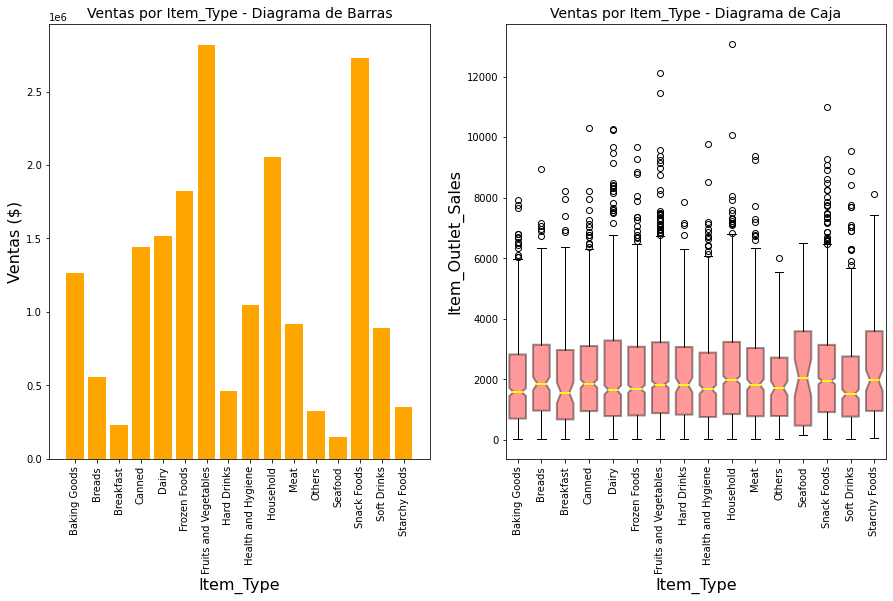

In [137]:
#Diagrama de caja
#Muestra la distribución de todas las ventas según las categorías de producto.
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15,8));
sales_item=df_final.groupby(['Item_Type'])[['Item_Outlet_Sales']].sum()

axes[0].bar(sales_item.index, sales_item.values.ravel(), color='orange')
axes[0].tick_params(axis='x', labelrotation=90)
axes[0].set_xlabel('Item_Type', fontsize=16)
axes[0].set_ylabel('Ventas ($)', fontsize=16)
axes[0].set_title('Ventas por Item_Type - Diagrama de Barras', fontsize=14);


tipos_item=sales_item.index
axes[1].boxplot([df_final.loc[df_final.Item_Type==tipos_item[0],'Item_Outlet_Sales']
              ,df_final.loc[df_final.Item_Type==tipos_item[1],'Item_Outlet_Sales']
              ,df_final.loc[df_final.Item_Type==tipos_item[2],'Item_Outlet_Sales']
              ,df_final.loc[df_final.Item_Type==tipos_item[3],'Item_Outlet_Sales']
              ,df_final.loc[df_final.Item_Type==tipos_item[4],'Item_Outlet_Sales']
              ,df_final.loc[df_final.Item_Type==tipos_item[5],'Item_Outlet_Sales']
              ,df_final.loc[df_final.Item_Type==tipos_item[6],'Item_Outlet_Sales']
              ,df_final.loc[df_final.Item_Type==tipos_item[7],'Item_Outlet_Sales']
              ,df_final.loc[df_final.Item_Type==tipos_item[8],'Item_Outlet_Sales']
              ,df_final.loc[df_final.Item_Type==tipos_item[9],'Item_Outlet_Sales']
              ,df_final.loc[df_final.Item_Type==tipos_item[10],'Item_Outlet_Sales']
              ,df_final.loc[df_final.Item_Type==tipos_item[11],'Item_Outlet_Sales']
              ,df_final.loc[df_final.Item_Type==tipos_item[12],'Item_Outlet_Sales']
              ,df_final.loc[df_final.Item_Type==tipos_item[13],'Item_Outlet_Sales']
              ,df_final.loc[df_final.Item_Type==tipos_item[14],'Item_Outlet_Sales']
              ,df_final.loc[df_final.Item_Type==tipos_item[15],'Item_Outlet_Sales']
              ],
           labels=tipos_item,             
           notch = True,
           widths = .7,
           patch_artist=True,
           medianprops = dict(linestyle='-', linewidth=2, color='Yellow'),
           boxprops = dict(linestyle='--', linewidth=2, color='Black', facecolor = 'red', alpha = .4)
          );
#plt.xticks(fontsize = 16, rotation=90 )
#plt.yticks(fontsize = 16)
axes[1].tick_params(axis='x', labelrotation=90)
axes[1].set_xlabel('Item_Type', fontsize=16)
axes[1].set_ylabel('Item_Outlet_Sales', fontsize=16);
axes[1].set_title('Ventas por Item_Type - Diagrama de Caja', fontsize=14);

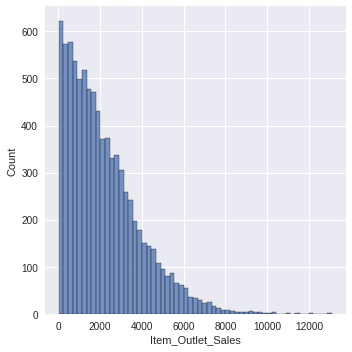

In [320]:
#Distribución de la variable objetivo 'Item_Outlet_Sales'
sns.displot(df_final['Item_Outlet_Sales']);

#Model (Parte 5)
* **¿Hay algo que puedas hacer para mejorar el modelo?**

Al eliminar las variables 'Item_Type', 'Outlet_Establishment_Year' y  'Outlet_Location_Type' se obtienen mejores resultados en ambos modelos, pero más notorio en el KNN. El KNN mejora reduciendo el número de vecinos, se lo deja en 2, para no caer en overfitting. Si se compara el R2, así como el RMSE el modelo KNN tiene mejores resultados.
* **¿Qué características están más asociadas con la predicción de ventas mayores?**

La variable 'Item_MRP' (variable numerica, se observa en la matriz de correlación su alto impacto en el target vector), así como la variable 'Outlet_Identifier'(su variabilidad, afecta en gran parte el resultado del target vector). 

En pocas, el precio de venta máximo (Item_MRP) así como la tienda donde se vende impacta en las ventas.

##Matriz de correlación, definición de matriz de características y target vector

In [140]:
#Almacenamos nuestro dataframe limpio en la variable data
data=df_final

In [141]:
#El Outlet_Establishment_Year, es el año de apertura de la tienda
#Convertimos la columna (variable) 'Outlet_Establishment_Year' en una variable categórica. 
data['Outlet_Establishment_Year']=data['Outlet_Establishment_Year'].astype(str)

In [142]:
#Matriz de correlación de variables
data.corr()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales
Item_Weight,1.000000,-0.006079,0.023618,0.015494
Item_Visibility,-0.006079,1.000000,-0.001155,-0.128297
Item_MRP,0.023618,-0.001155,1.000000,0.567803
Item_Outlet_Sales,0.015494,-0.128297,0.567803,1.000000


In [143]:
data.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

In [144]:
#Matriz de caraterísticas
#La variable 'Outlet_Size' no se toma en cuenta por incompleta
#Se obtiene mejores resultados eliminando las variables: 
#'Item_Type','Outlet_Establishment_Year', 'Outlet_Location_Type', 
X=data[['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 
        'Item_MRP', 'Outlet_Identifier', 'Outlet_Type']]
#Target Vector
y=data['Item_Outlet_Sales'].values
#One Hot Encoder, para las variables categóricas.
ohe = ce.OneHotEncoder(handle_unknown='ignore', use_cat_names=True)
X_ohe = ohe.fit_transform(X)
X=X_ohe.values
X.shape

(8519, 1574)

##Regresión Lineal y KNN

In [145]:
#Regresión Lineal
reg=LinearRegression(fit_intercept=True)
reg.fit(X,y)
#Predicciones del modelo
preds_reg = reg.predict(X)
#Parámetros de medición, R2, MAE & RMSE
reg_r2 = reg.score(X,y)
reg_mae = mean_absolute_error(y,preds_reg)
reg_rmse = np.sqrt(mean_squared_error(y,preds_reg))

In [146]:
#Regresión KNN
#Estandarización de la matriz de características
scaler=StandardScaler()
scaler.fit(X)
X1=scaler.transform(X)
knn=KNeighborsRegressor(n_neighbors=2)
knn.fit(X1,y)
#Predicciones del modelo
preds_knn = knn.predict(X1)
#Parámetros de medición, R2, MAE & RMSE
knn_r2 = knn.score(X1,y)
knn_mae = mean_absolute_error(y,preds_knn)
knn_rmse = np.sqrt(mean_squared_error(y,preds_knn))

In [148]:
#Comparación de resultados
print("Regresión Lineal\tRegresion KNN (Neighbors=2)\nr2 =\t{:.3f}\t\t{:.3f}\nMAE =\t{:.3f}\t\t{:.3f}\nRMSE =\t{:.3f}\t{:.3f}".format(reg_r2,knn_r2,reg_mae,knn_mae,reg_rmse,knn_rmse))

Regresión Lineal	Regresion KNN (Neighbors=2)
r2 =	0.643		0.744
MAE =	760.984		620.127
RMSE =	1019.236	863.057
